# 神經網路訓練的範例

請注意，很多程式碼都放在 modules 資料中。

In [1]:
import numpy as np
from modules import train
from modules import layers

## 單純的多層神經網路

In [2]:
# 神經網路容器
# NeuralNetwork 類別負責管理整個模型的結構（層與參數），並提供前向傳播、反向傳播、正則化等功能
class NeuralNetwork:   
    def __init__(self):
        # _layers: 儲存所有層物件（如 Conv, Pool, Dense）的清單
        # _params: 儲存所有可訓練參數（權重與梯度）的引用，方便優化器更新
        self._layers = []
        self._params = []
 
    def add_layer(self, layer):      
        self._layers.append(layer)
        # 如果該層有可訓練參數（如權重 W），則將其參數與對應梯度加入管理清單
        if layer.params: 
            for i, _ in enumerate(layer.params):                         
                self._params.append([layer.params[i], layer.grads[i]])  
                
    def forward(self, X): 
        # 前向傳播：將資料 X 依序流過每一層，每一層的輸出作為下一層的輸入
        for layer in self._layers:            
            X = layer.forward(X) 
        return X   
    
    def __call__(self, X):
        # 語法糖：讓你可以像呼叫函數一樣使用模型，例如 model(X)
        return self.forward(X)
    
    def predict(self, X):
        # 預測模式：取得前向傳播最後的機率分佈，並回傳機率最大的索引（類別）
        p = self.forward(X)       
        if p.ndim == 1:     # 單一樣本處理
            return np.argmax(p)   
        return np.argmax(p, axis=1)
    
    def backward(self, loss_grad, reg = 0.):
        # 反向傳播：從最後一層往第一層傳遞梯度（reversed）
        # loss_grad: 損失函數對輸出的初始梯度
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i] 
            loss_grad = layer.backward(loss_grad)
            # 計算該層參數的正規化梯度（防止過擬合）
            layer.reg_grad(reg) 
        return loss_grad
    
    def reg_loss(self, reg):
        # 正規化損失：加總每一層的權重懲罰項（如 L2 Regularization）
        reg_loss = 0
        for i in range(len(self._layers)):
            reg_loss += self._layers[i].reg_loss(reg)
        return reg_loss
    
    def parameters(self): 
        # 回傳模型中所有「權重與梯度」的配對
        return self._params
    
    def zero_grad(self):
        # 梯度歸零：在每一輪新的訓練開始前，必須將舊的梯度清空，避免累加
        for i, _ in enumerate(self._params):
            self._params[i][1] *= 0.

In [3]:
def gen_spiral_dataset(N=100, D=2, K=3):
    X = np.zeros((N*K, D))  # 建立資料矩陣，每一列代表一筆資料
    y = np.zeros(N*K, dtype='uint8')  # 建立標籤陣列，用來存每筆資料的類別

    for j in range(K):  # 依序產生每一個類別的資料
        ix = range(N*j, N*(j+1))  # 計算目前類別在資料中的索引範圍
        r = np.linspace(0.0, 1, N)  # 半徑，從中心往外均勻增加
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2  # 角度，加上一點雜訊讓資料比較分散
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]  # 轉成平面座標，形成螺旋狀
        y[ix] = j  # 設定對應的類別標籤

    return X, y  # 回傳資料與標籤

def softmax(Z):
    # 對輸入的 Z 做 softmax，先減掉最大值避免數值爆掉
    A = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    # 將指數結果做正規化，讓每一列加起來等於 1
    return A / np.sum(A, axis=-1, keepdims=True)

def cross_entropy_grad_loss(Z, y, softmax_out=False, onehot=False):
    """
    優化後的函式：共用 Softmax 運算結果，同時回傳 Loss 與 Gradient。
    """
    # 1. 決定機率分布 F (Softmax 的結果)
    if softmax_out:
        # 如果已經是 Softmax 輸出，直接共用
        F = Z
    else:
        # 如果是 Logits，算一次 Softmax 就好，後面大家都用這份 F
        F = softmax(Z)

    # 2. 計算 Loss
    # 注意：這裡我們傳入已經算好的 F，並告訴後面的函式 softmax_out=True
    # (假設你原有的 softmax_cross_entropy 有支援這個判斷，或是我們直接在這裡算)
    m = len(y)
    if onehot:
        loss = -np.sum(y * np.log(F + 1e-12)) / m
    else:
        # 這裡示範直接計算，減少函式呼叫的開銷
        loss = -np.sum(np.log(F[np.arange(m), y] + 1e-12)) / m

    # 3. 計算梯度 (Gradient)
    # 直接利用剛剛算好的 F 進行計算，效能最優
    grad = F.copy()
    if onehot:
        grad = (grad - y) / m
    else:
        grad[np.arange(m), y] -= 1
        grad /= m

    return loss, grad

In [4]:
# 固定隨機種子，確保每次訓練的初始化權重一致，方便實驗比對
np.random.seed(1)

# 初始化神經網路容器
nn = NeuralNetwork()

# 搭建網路架構：
# 第一層全連接層 (Dense)：輸入 2 維 (x, y 座標)，輸出 100 維
nn.add_layer(layers.Dense(2, 100))
# 激發函數 (Activation)：使用 Relu 增加模型的非線性表達能力
nn.add_layer(layers.Relu())
# 第二層全連接層 (輸出層)：將 100 維映射到 3 個類別 (對應 y 的種類)
nn.add_layer(layers.Dense(100, 3)) 

# 產生測試資料：X 為座標點，y 為標籤 (0, 1, 2)
X, y = gen_spiral_dataset(N=100, D=2, K=3)

# 設定優化器 (Optimizer)：使用帶有動量 (Momentum) 的隨機梯度下降
# nn.parameters() 會將網路中所有層的權重與梯度交給優化器管理
learning_rate = 1e-1
momentum = 0.9
optimizer = train.SGD(nn.parameters(), learning_rate, momentum)

# 設定超參數 (Hyperparameters)
epochs = 5000         # 總訓練輪數
batch_size = len(X)   # 批次大小，這裡使用 Full Batch 訓練
reg = 0.5e-3          # 正規化係數 (L2 Regularization)，避免權重過大導致過擬合
print_n = 300         # 每隔多少輪印出一次損失值 (Loss)

# 開始訓練：執行前向傳播、計算誤差、反向傳播並更新參數
losses = train.train_nn(nn, X, y, optimizer, cross_entropy_grad_loss, 
                        epochs, batch_size, reg, print_n)

# 評估模型：計算訓練後的準確度 (Accuracy)
print(np.mean(nn.predict(X) == y))

[反覆次數     1, 第 1 個 Epoch] loss: 1.123
[反覆次數   301, 第 301 個 Epoch] loss: 0.292
[反覆次數   601, 第 601 個 Epoch] loss: 0.259
[反覆次數   901, 第 901 個 Epoch] loss: 0.249
[反覆次數  1201, 第 1201 個 Epoch] loss: 0.244
[反覆次數  1501, 第 1501 個 Epoch] loss: 0.242
[反覆次數  1801, 第 1801 個 Epoch] loss: 0.241
[反覆次數  2101, 第 2101 個 Epoch] loss: 0.241
[反覆次數  2401, 第 2401 個 Epoch] loss: 0.240
[反覆次數  2701, 第 2701 個 Epoch] loss: 0.240
[反覆次數  3001, 第 3001 個 Epoch] loss: 0.240
[反覆次數  3301, 第 3301 個 Epoch] loss: 0.240
[反覆次數  3601, 第 3601 個 Epoch] loss: 0.239
[反覆次數  3901, 第 3901 個 Epoch] loss: 0.239
[反覆次數  4201, 第 4201 個 Epoch] loss: 0.239
[反覆次數  4501, 第 4501 個 Epoch] loss: 0.239
[反覆次數  4801, 第 4801 個 Epoch] loss: 0.239
0.99


## 以 MNIST 手寫數字資料集來訓練 CNN

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_path = "Data/mnist_train.csv"  # 例如："/content/mnist_train.csv"
test_path  = "Data/mnist_test.csv"   # 例如："/content/mnist_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_X = train_df.drop(columns=['label']).values
train_y = train_df['label'].values

print(train_X.shape)
train_X = train_X.reshape((train_X.shape[0],1,28,28)) / 255.0
print(train_X.shape)

(60000, 784)
(60000, 1, 28, 28)


In [8]:
import time
from modules import train
from modules import layers
from modules import util
from modules import train

# 固定隨機種子，確保每次跑實驗的結果可以被復現 (Reproducible)
np.random.seed(1)

# 初始化神經網路物件
# nn = ConvNetwork()
nn = NeuralNetwork()                    

# 疊加層 (Layers)
# 第一層卷積層：輸入 1 通道, 輸出 2 通道, 核心大小 5x5, 步長 1, 補零 0
nn.add_layer(layers.Conv(1, 2, 5, 1, 0))    # 特徵圖變化：1*28*28 -> 2*24*24
# 池化層：使用 2x2x2 的維度進行下採樣 (Downsampling)
nn.add_layer(layers.Pool((2, 2, 2)))        # 特徵圖變化：-> 2*12*12
# 第二層卷積層
nn.add_layer(layers.Conv(2, 4, 5, 1, 0))    # 特徵圖變化：-> 4*8*8
# 第二層池化層
nn.add_layer(layers.Pool((2, 2, 2)))        # 特徵圖變化：-> 4*4*4
# 全連接層 (Dense/Linear Layer)：將特徵壓平後輸入 100 個神經元
nn.add_layer(layers.Dense(64, 100))
# 激發函數 (Activation Function)：使用 ReLU 增加非線性擬合能力
nn.add_layer(layers.Relu())
# 輸出層：最後輸出 10 個類別（對應數字 0-9）
nn.add_layer(layers.Dense(100, 10)) 

# 超參數 (Hyperparameters) 設定
learning_rate = 1e-3  # 學習率 1e-1
momentum = 0.9        # 動量
optimizer = train.SGD(nn.parameters(), learning_rate, momentum) # 使用 SGD 優化器

epochs = 1            # 訓練輪數
batch_size = 64       # 每個批次的大小
reg = 1e-3            # 正則化係數 (防止過擬合)
print_n = 100         # 每隔多少個 iteration 印一次日誌

start = time.time()

# 準備訓練資料
X, y = train_X, train_y

# 開始跑訓練流程
# 使用 Cross Entropy 作為 Loss Function
losses = train.train_nn(nn, X, y, optimizer, util.cross_entropy_grad_loss, epochs, batch_size, reg, print_n)

done = time.time()
elapsed = done - start
print(f"訓練花費時間: {elapsed:.2f} 秒")

# 計算在訓練集上的準確度 (Accuracy)
print(f"訓練集準確率: {np.mean(nn.predict(X) == y) * 100:.2f}%")

[反覆次數     1, 第 1 個 Epoch] loss: 2.340
[反覆次數   101, 第 1 個 Epoch] loss: 2.329
[反覆次數   201, 第 1 個 Epoch] loss: 2.338
[反覆次數   301, 第 1 個 Epoch] loss: 2.287
[反覆次數   401, 第 1 個 Epoch] loss: 2.186
[反覆次數   501, 第 1 個 Epoch] loss: 1.728
[反覆次數   601, 第 1 個 Epoch] loss: 0.793
[反覆次數   701, 第 1 個 Epoch] loss: 0.753
[反覆次數   801, 第 1 個 Epoch] loss: 0.627
[反覆次數   901, 第 1 個 Epoch] loss: 0.571
訓練花費時間: 683.22 秒
訓練集準確率: 86.19%


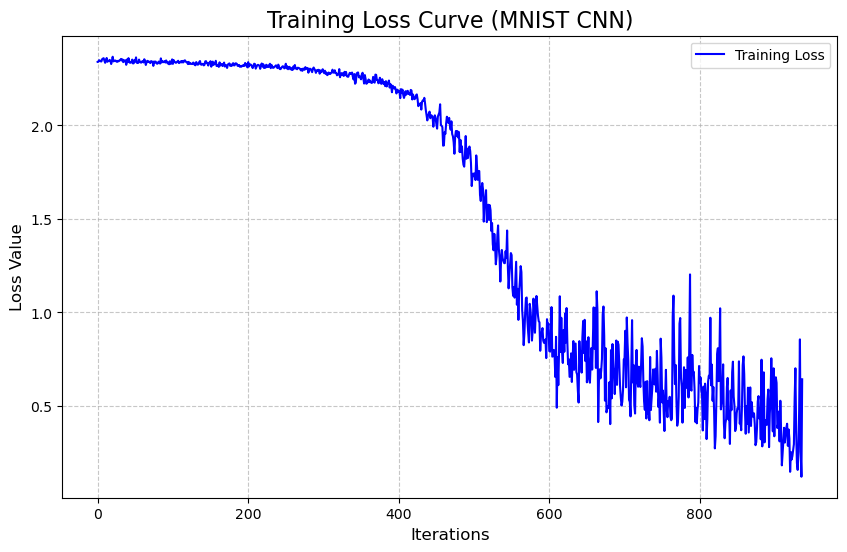

In [9]:
import matplotlib.pyplot as plt

# 讓 matplotlib 在 Jupyter Notebook 中直接顯示圖片
%matplotlib inline

# 設定圖片大小，讓曲線看起來更清楚
plt.figure(figsize=(10, 6))

# 繪製 Loss 曲線
plt.plot(losses, label='Training Loss', color='blue')

# --- 增加讓圖片更易讀的內容 ---

# 圖片標題 (Title)
plt.title('Training Loss Curve (MNIST CNN)', fontsize=16)

# X 軸標籤：通常是 Iteration (次數) 或 Batch
plt.xlabel('Iterations', fontsize=12)

# Y 軸標籤：Loss 值
plt.ylabel('Loss Value', fontsize=12)

# 增加網格線 (Grid)，方便觀察數值變動的區間
plt.grid(True, linestyle='--', alpha=0.7)

# 增加圖例 (Legend)
plt.legend()

# 顯示圖片
plt.show()

In [10]:
# 1. 分離特徵與標籤
test_X = test_df.drop(columns=['label']).values
test_y = test_df['label'].values

# 2. Reshape 與正規化 (Normalization)
# 注意：這裡的處理必須跟訓練集完全同步！
test_X = test_X.reshape((test_X.shape[0], 1, 28, 28)) / 255.0

# 3. 讓模型進行預測 (Inference)
test_preds = nn.predict(test_X)

# 4. 計算測試集準確率
test_acc = np.mean(test_preds == test_y)
print(f"--- 測試集結果 ---")
print(f"測試集準確率 (Test Accuracy): {test_acc * 100:.2f}%")

--- 測試集結果 ---
測試集準確率 (Test Accuracy): 86.92%


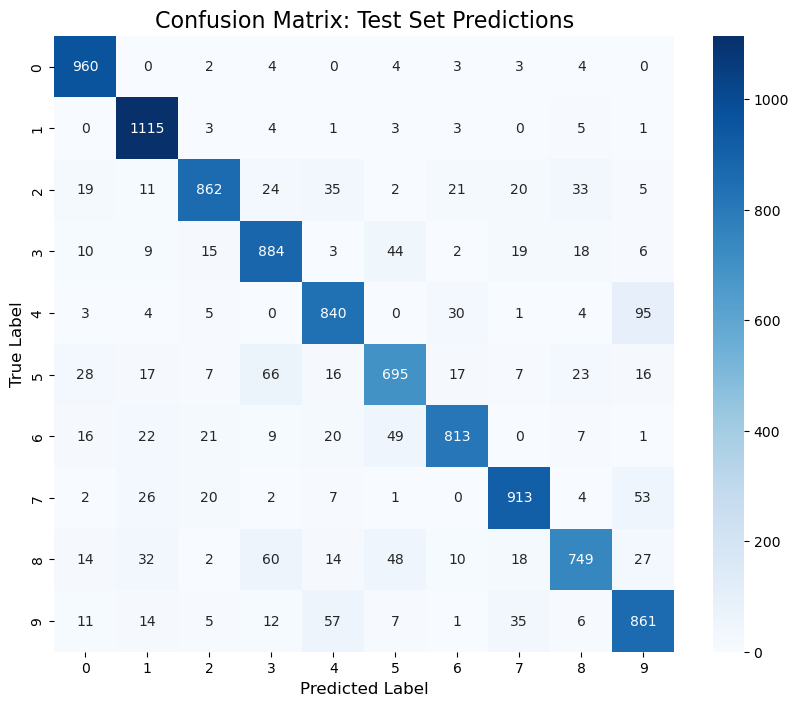

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 計算混淆矩陣
cm = confusion_matrix(test_y, test_preds)

# 畫圖
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Test Set Predictions', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

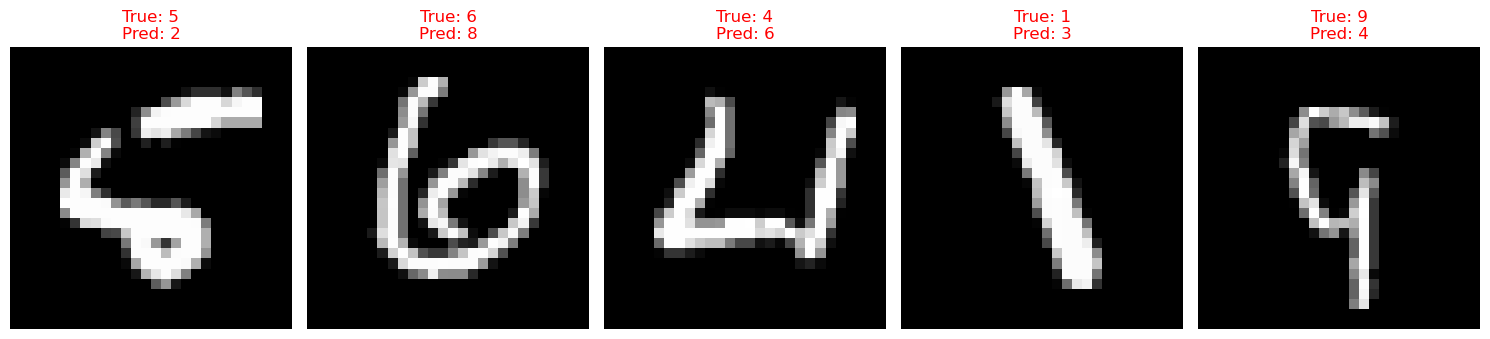

In [12]:
# 找出預測錯誤的索引
error_indices = np.where(test_preds != test_y)[0]

# 隨機挑 5 張錯誤的圖片來看
plt.figure(figsize=(15, 5))
for i, idx in enumerate(error_indices[:5]):
    plt.subplot(1, 5, i + 1)
    # 將資料 reshape 回 28x28 顯示
    plt.imshow(test_X[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {test_y[idx]}\nPred: {test_preds[idx]}", color='red')
    plt.axis('off')
plt.tight_layout()
plt.show()